In [1]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import sys
from IPython.display import HTML
from matplotlib import pyplot as plt
from celluloid import Camera
import plotly.graph_objects as go

import networkx as nx

from IPython.display import HTML
from matplotlib import pyplot as plt
from celluloid import Camera
import collections

In [2]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd="enron",
  database="emails",
  auth_plugin='mysql_native_password'
)

In [3]:
mycursor = mydb.cursor()

# Extract Data to Pandas

mycursor.execute("SELECT * FROM message")

myresult = mycursor.fetchall()

email_df = pd.DataFrame(myresult)

email_df.columns = ['mid','sender','date','message_id','subject','body','folder']



mycursor.execute("SELECT * FROM employeelist")

myresult = mycursor.fetchall()

employee_df = pd.DataFrame(myresult)

employee_df.columns = ['eid','first_name','last_name','email_id']



mycursor.execute("SELECT * FROM recipientinfo")

myresult = mycursor.fetchall()

recipient_df = pd.DataFrame(myresult)

recipient_df.columns = ['rid','mid','r_type','r_value','date_r']



mycursor.execute("SELECT * FROM referenceinfo")

myresult = mycursor.fetchall()

reference_df = pd.DataFrame(myresult)

reference_df.columns = ['rfid','mid','reference']



# Data Frame Characteristics

In [4]:
jobs = pd.read_csv('Data/Enron_jobs.csv')
employee_df = pd.merge(employee_df,jobs,on='email_id',how='left')
job_dict = {}
level_dict = {}

In [5]:
for email,level,job in zip(employee_df['email_id'],employee_df['job_rank'],employee_df['job_title']):
    job_dict[email] = job
    level_dict[email] = level

In [6]:
main_emails = list(employee_df['email_id'])

In [7]:
recipient_df = recipient_df[[email in main_emails for email in recipient_df['r_value']]]
email_df = email_df[[email in main_emails for email in email_df['sender']]]

In [8]:
# create mapping of messages to lists of recipients and how many recipients that email has
mid_dict = {}
count =0
total = len(recipient_df)
for mid,r_value in zip(recipient_df['mid'],recipient_df['r_value']) :
    if mid in mid_dict.keys():
        mid_dict[mid].append(r_value)
    else:
        mid_dict[mid] = [r_value]

(0, 5000)

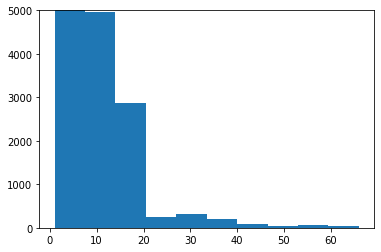

In [9]:
network_df = pd.DataFrame()

network_df['mid'] = list(set(recipient_df['mid']))


lst = []
lst_num = []
for mid in network_df['mid']:
    lst.append(mid_dict[mid])
    lst_num.append(len(mid_dict[mid]))
network_df['rec_list'] = lst
network_df['rec_count'] = lst_num


plt.hist(network_df['rec_count'])
plt.ylim(0,5000)

In [10]:
network_df = network_df.merge(email_df[['mid','sender','date']])

network_df.head()

mid                                           rec_list  rec_count  \
0   76  [sean.crandall@enron.com, mike.swerzbin@enron....          3   
1   93                          [robert.badeer@enron.com]          1   
2  159  [robert.badeer@enron.com, mike.swerzbin@enron....          2   
3  465                        [richard.shapiro@enron.com]          1   
4  517                        [richard.shapiro@enron.com]          1   

                    sender                 date  
0      mary.hain@enron.com  2000-08-17 07:11:00  
1  cooper.richey@enron.com  2000-08-23 04:39:00  
2      mary.hain@enron.com  2000-08-29 06:28:00  
3  jeff.dasovich@enron.com  2000-08-07 12:23:00  
4  jeff.dasovich@enron.com  2000-08-10 03:12:00

In [11]:
sender_count_dict = {}
for sender in set(network_df['sender']):
    sender_count_dict[sender] = len(set(network_df[network_df['sender']==sender]['mid']))


In [12]:
email_to_id = {}
id_to_email ={}
count = 0
for user in main_emails:
    email_to_id[user] = count
    id_to_email[count] = user
    count+=1

In [13]:
central_id = email_to_id['jeff.skilling@enron.com']
central_id

129

In [14]:
user_matrix = np.zeros((len(main_emails),len(main_emails)))

In [15]:
for sender ,rec_list,rec_count in zip(network_df['sender'],network_df['rec_list'],network_df['rec_count']):
    for recer in rec_list:
        user_matrix[email_to_id[sender]][email_to_id[recer]] += (1/rec_count)*sender_count_dict[sender]

In [16]:
G = nx.Graph()

In [17]:
G.add_nodes_from(range(len(user_matrix)))

In [18]:
# create list of edge weights to cut by percentile
edge_values = list(user_matrix)
l =[]
for edges in edge_values:
    l = l + list(edges)
edge_values = l

In [19]:
edge_thresh = np.percentile(edge_values,95)
for i in range(len(user_matrix)):
    for j in range(len(user_matrix)):
        #if i ==jeff_sig_id:
                #print('jeff_potential')
        if user_matrix[i][j] > edge_thresh:
            if i ==central_id:
                print('jeff_connection')
            G.add_edge(i,j)

In [20]:
eigen_dict = nx.eigenvector_centrality(G)
eigen_thresh = np.percentile(list(eigen_dict.values()),90)
for key in eigen_dict.keys():
    if eigen_dict[key]>eigen_thresh:
        print(eigen_dict[key],' : ',id_to_email[key],level_dict[id_to_email[key]])

0.16209950089223857  :  mike.grigsby@enron.com Manager
0.14667260132839585  :  d..steffes@enron.com Vice President
0.1519402303067726  :  elizabeth.sager@enron.com Employee
0.16468942024300331  :  shelley.corman@enron.com Vice President
0.14816992573629506  :  barry.tycholiz@enron.com Vice President
0.1412662327876826  :  john.arnold@enron.com Vice President
0.16990836082379315  :  tana.jones@enron.com nan
0.18353859924033475  :  susan.scott@enron.com nan
0.15562972518749588  :  sara.shackleton@enron.com nan
0.15418760754707636  :  richard.shapiro@enron.com Vice President
0.21146764992892372  :  jeff.dasovich@enron.com Employee
0.17068004726266733  :  gerald.nemec@enron.com nan
0.15293435831820196  :  m..presto@enron.com Vice President
0.27748152318049457  :  louise.kitchen@enron.com President
0.16309743499389456  :  drew.fossum@enron.com Vice President


In [21]:
ranks = ['CEO','President','Vice President','Director']

In [22]:
level_num_dict = {}
for node in G.nodes():
    for i in range(len(ranks)):
        if ranks[i] == level_dict[id_to_email[node]]:
            level_num_dict[node] = i
            continue
    if node not in level_num_dict:
        level_num_dict[node] = len(ranks)

In [23]:
rank_list = []
for i in range(10):
    i_range_list = []
    for key,value in level_num_dict.items():
        if level_num_dict[key] ==i:
            i_range_list.append(key)
    rank_list.append(i_range_list)
while [] in rank_list:
    rank_list.remove([])

In [24]:
job_count = collections.Counter()
for rank in jobs['job_rank']:
    job_count[rank] +=1

In [25]:
job_count

Counter({'Employee': 41,
         'Vice President': 30,
         nan: 55,
         'Director': 14,
         'President': 5,
         'Manager': 17,
         'Trader': 11,
         'CEO': 5,
         'Managing Director': 6,
         'In House Lawyer': 1})

In [26]:
plotly_color = ['red','orange','yellow','purple','green','black','black','black','black','black','black']
node_size = [900,600,400,300,200,100,100,100,100,100]

colors_plotly = []
sizes_node = []


for node_num in list(G.nodes()):
    colors_plotly.append(plotly_color[level_num_dict[node_num]])
    sizes_node.append(node_size[level_num_dict[node_num]])

In [27]:
pos = {}
for i in range(len(rank_list)):
    x = -1 + i/5
    for j in range(len(rank_list[i])):
        pos[rank_list[i][j]] = (x,1/len(rank_list[i])*j) 
heir_pos = pos

In [28]:
#Vizualize Network Based on Job Ranks

//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



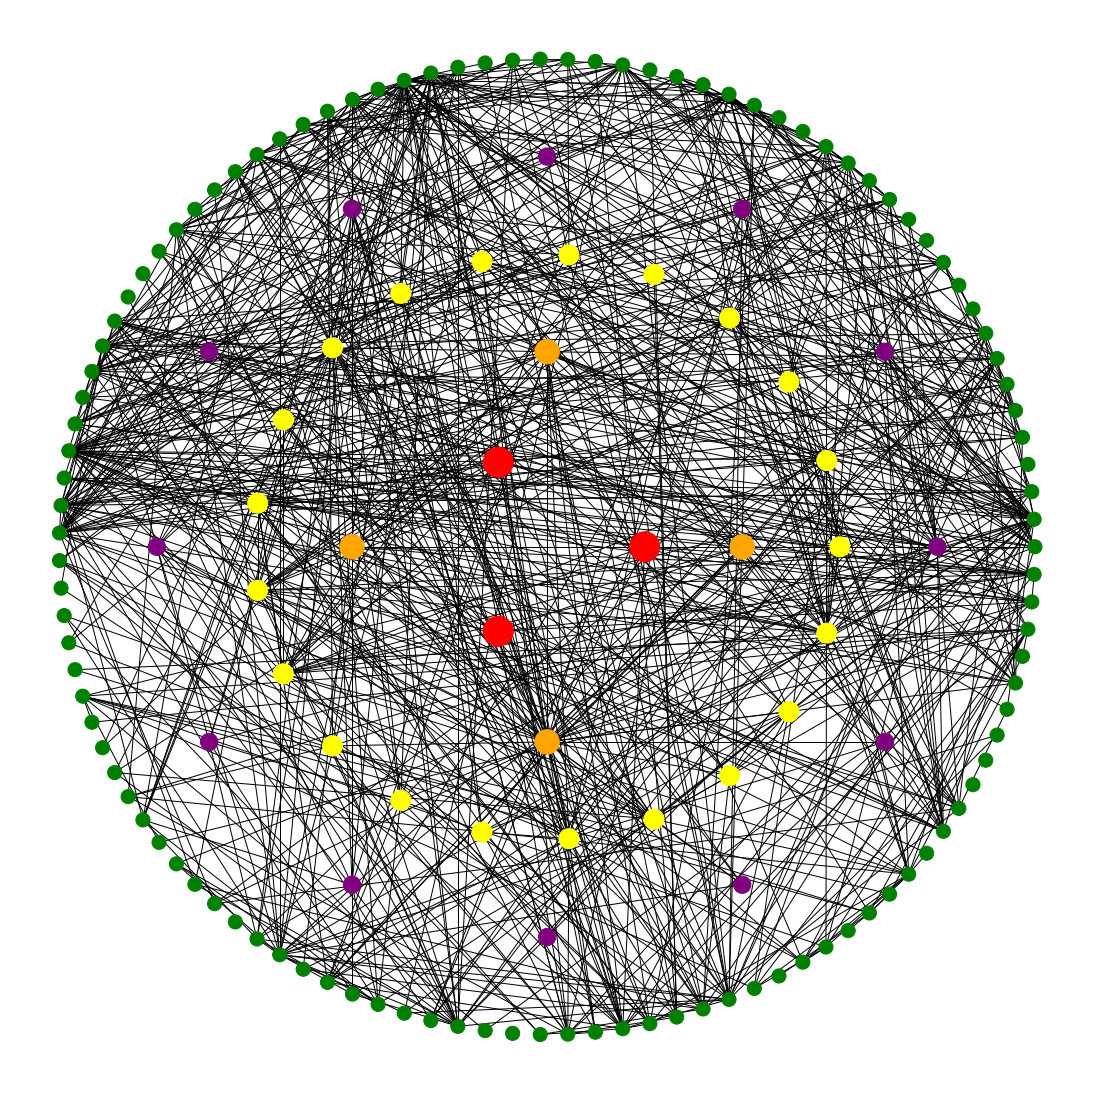

In [29]:
fig = plt.figure(figsize=(15,15))
pos = nx.shell_layout(G,rank_list)
nx.draw(G, pos= pos,node_size=sizes_node,node_color=colors_plotly)

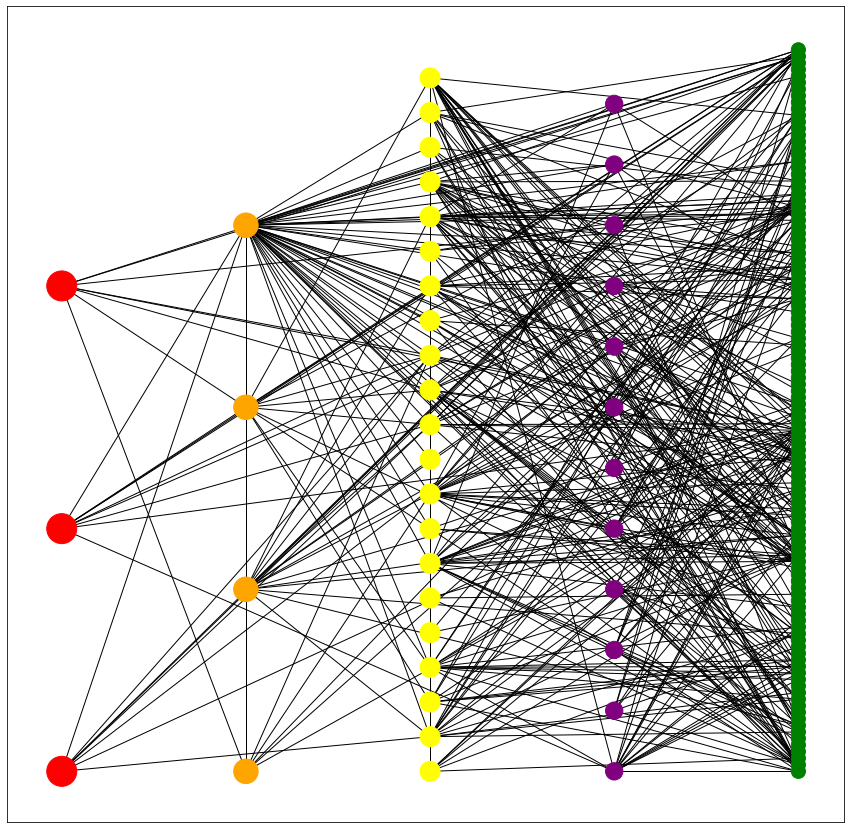

In [32]:
fig = plt.figure(figsize=(15,15))

pos = nx.shell_layout(G,rank_list)
nx.draw_networkx_nodes(G, pos= heir_pos,node_size=sizes_node,node_color=colors_plotly)
    

nx.draw_networkx_edges(G,pos=heir_pos)


In [34]:
set_edges = []
for node in rank_list[0]:
    set_edges = set_edges +list(G.edges(node))

//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



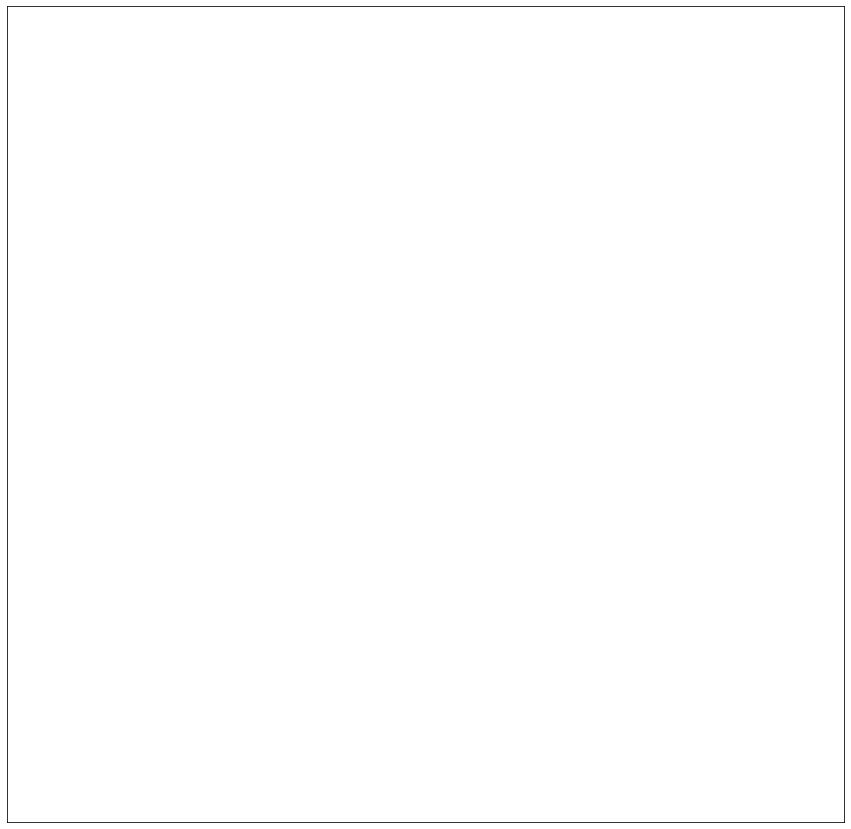

In [36]:
fig = plt.figure(figsize=(15,15))
camera = Camera(fig)
for i in range(len(rank_list)):
    set_edges = []
    
    for node in rank_list[i]:
        set_edges = set_edges +list(G.edges(node))
    nx.draw_networkx_nodes(G, pos= heir_pos,node_size=sizes_node,node_color=colors_plotly)
    nx.draw_networkx_edges(G,pos=heir_pos,edgelist=set_edges)
    camera.snap()
    
animation = camera.animate(interval=500)
animation.save('HeirarchyModel.gif', writer='imagemagick')
HTML(animation.to_jshtml())